### Building onto saved dataframe,  following  function appends/extends new records to existing dataset using 'n' bernouli trials.

In [1]:
import pandas as pd
import numpy as np
#from numpy.random import seed
#seed(1)

ltrait_new = np.linspace(-4,4, num=100)#np.random.normal(0, 1, size=100)
num_sim_users = ltrait_new.shape[0]
num_sim_items = 3
print('# of sim user:',num_sim_users,'\n# of sim items:',num_sim_items)

# of sim user: 100 
# of sim items: 3


In [2]:
def add_data(array, trials_per_user):
    array_li= array.tolist()#list of tuples
    dock_list=list()#holds tuples generated from trials
    for u, i, prob in array_li:
        success_failure_arr = np.random.binomial(1, prob, trials_per_user)
        
        for resp in success_failure_arr:
            dock_list.append([u,i, resp])
        
    array_li+=dock_list
    return np.array(array_li)

In [3]:
df_cols = ['user','questions', 'response']

c_probs= pd.read_csv('simulated_data_c_probs.csv')
df_mat = add_data(c_probs.values, trials_per_user=10)
df_sim = pd.DataFrame(df_mat, columns=df_cols)
print('Extended df size:', df_sim.shape)

Extended df size: (3300, 3)


In [4]:
df_sim['response']=df_sim['response'].apply(lambda x: int(np.round(x)))
df_sim.head(3)

,user,questions,response
0,92.0,0.0,1
1,86.0,2.0,1
2,57.0,1.0,1


### Defining a GLM class for two parameterization schemes for 3PL keras models which are as:
**Scheme 1.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * a_j= discrimination parameter of j-th question
        * c_j= pseudo guessing parameter of j-th question
    
**Scheme 2.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[alpha_j + lamda_j*t_i]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * `lamda_j / a_j`= discrimination parameter of j-th question
        * alpha_j= -lam_j*b_j.
        * c_j = pseudo guessing parameter of j-th question

        



### Now using  dataset  from above, train a keras 1/2/3PL proxy models model using an mlsquare adapter.

In [6]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_sim[df_cols[:-1]], df_sim[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

shape of simulated x_train_user: (3135, 100) 
shape of simulated  x_train_questions: (3135, 3) 
shape of simulated  y_train: (3135,)


#### View regsitered IRT proxy models & adapters from mlsquare registry

In [7]:
from mlsquare import registry
reg= registry.data
reg

2020-01-03 22:52:08,696	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-01-03_22-52-08_8375/logs.
2020-01-03 22:52:08,836	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:45037 to respond...
2020-01-03 22:52:08,970	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:39920 to respond...
2020-01-03 22:52:08,978	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2020-01-03 22:52:09,020	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.


{('mlsquare',
  'rasch'): {'default': [<mlsquare.architectures.sklearn.KerasIrt1PLModel at 0x7f2e14065e10>,
   mlsquare.adapters.sklearn.IrtKerasRegressor]},
 ('mlsquare',
  'twoPl'): {'default': [<mlsquare.architectures.sklearn.KerasIrt2PLModel at 0x7f2dc73e6a58>,
   mlsquare.adapters.sklearn.IrtKerasRegressor]},
 ('mlsquare',
  'tpm'): {'default': [<mlsquare.architectures.sklearn.KerasIrt3PLModel at 0x7f2dc73e6c18>,
   mlsquare.adapters.sklearn.IrtKerasRegressor]},
 ('sklearn',
  'TruncatedSVD'): {'default': [<mlsquare.architectures.sklearn.SVD at 0x7f2dc712c0f0>,
   mlsquare.adapters.sklearn.SklearnTfTransformer]},
 ('sklearn',
  'LogisticRegression'): {'default': [<mlsquare.architectures.sklearn.LogisticRegression at 0x7f2dc712c5c0>,
   mlsquare.adapters.sklearn.SklearnKerasClassifier]},
 ('sklearn',
  'LinearRegression'): {'default': [<mlsquare.architectures.sklearn.LinearRegression at 0x7f2dc712c780>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'Ridge'): 

* Primal models' signature params are defined in reference to R's ltm package, along the lines of sklearn.

In [8]:
from mlsquare.embibe.irt import rasch

In [9]:
primal= rasch()
primal

rasch(Hessian=True, IRT_param=True, constraint='NULL', control=[], data=None,
      na_action='NULL', start_val='NULL')

In [10]:
rasch

mlsquare.embibe.irt.rasch

In [11]:
rasch().__class__.__name__#1PL model_name in registry

'rasch'

In [12]:
rasch().__class__.__module__#1PL module_name in registry

'mlsquare.embibe.irt'

In [13]:
from mlsquare.utils.functions import _get_model_name, _get_module_name
module_name = _get_module_name(primal)
model_name = _get_model_name(primal)

print(module_name, model_name)#consistent with registry

mlsquare rasch


## Doping Rasch(1PL) primal model class & performing a fit.

In [14]:
from mlsquare import dope

In [15]:
from mlsquare.embibe.irt import rasch

primal1= rasch()
primal1

rasch(Hessian=True, IRT_param=True, constraint='NULL', control=[], data=None,
      na_action='NULL', start_val='NULL')

In [16]:
model1pl= dope(primal1)#proxy, adap = reg[('embibe','irt')]['3PL']

Transpiling your model to it's Deep Neural Network equivalent...


In [17]:
#mod3PL = adap(proxy_model=proxy, primal_model='abc')#adapt object
model1pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=512)


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 512;
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Training on : 3135 samples for : 512 epochs has completed in : 13.579 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [18]:
model1pl.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

#### Obtaining underlying trained Rasch(1pl) parameters from doped model

In [19]:
model1pl.coefficients()

{'difficulty_level': array([[-0.5632423 ],
        [-0.02854169],
        [ 0.4119939 ]], dtype=float32), 'disc_param': array([[1.],
        [1.],
        [1.]], dtype=float32), 'guessing_param': array([[0.],
        [0.],
        [0.]], dtype=float32)}

* **Train Vs. Validation loss curves for simulated dataset**

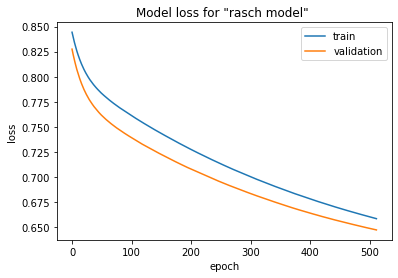

In [20]:
model1pl.plot()

________________________

## Doping twoPl(2PL) primal model class & performing a fit.

In [21]:
from mlsquare.embibe.irt import twoPl

primal2= twoPl()
primal2

twoPl(Hessian=True, IRT_param=True, constraint='NULL', control=[], data=None,
      na_action='NULL', start_val='NULL')

In [22]:
model2pl= dope(primal2)

Transpiling your model to it's Deep Neural Network equivalent...


In [23]:
model2pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=512)


Intitializing fit for twoPl model. . .
Batch_size: 64; epochs: 512;

Training on : 3135 samples for : 512 epochs has completed in : 14.803 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [24]:
model2pl.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

* **Train Vs. Validation loss curves for simulated dataset**

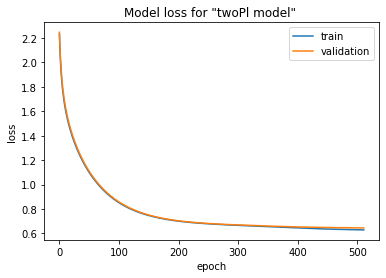

In [25]:
model2pl.plot()

#### Obtaining underlying trained 2pl parameters from doped model

In [26]:
model2pl.coefficients()

{'difficulty_level': array([[-0.2497371 ],
        [ 0.00812508],
        [ 0.47071078]], dtype=float32), 'disc_param': array([[1.8969175 ],
        [8.287977  ],
        [0.78989387]], dtype=float32), 'guessing_param': array([[0.],
        [0.],
        [0.]], dtype=float32)}

_________________________

## Doping tpm(3PL) primal model class & performing a fit

In [27]:
from mlsquare.embibe.irt import tpm

primal3= tpm()
primal3

tpm(IRT_param=None, constraint='NULL', control=[], data=None, max_guessing=1,
    na_action='NULL', start_val='NULL', typ=None)

In [28]:
model3pl=dope(primal3)

Transpiling your model to it's Deep Neural Network equivalent...


In [29]:
model3pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=512)


Intitializing fit for tpm model. . .
Batch_size: 64; epochs: 512;

Training on : 3135 samples for : 512 epochs has completed in : 15.071 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [30]:
model3pl.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

* **Train Vs. Validation loss curves for simulated dataset**

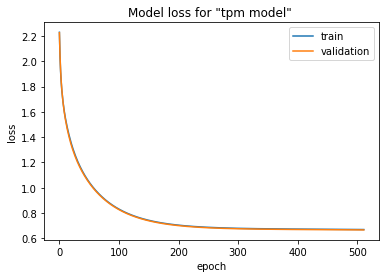

In [31]:
model3pl.plot()

#### Obtaining underlying trained tpm(3pl) parameters from doped model

In [32]:
model3pl.coefficients()

{'difficulty_level': array([[-0.42673725],
        [-0.04417013],
        [ 0.37209222]], dtype=float32), 'disc_param': array([[0.928485  ],
        [0.41180617],
        [1.3610762 ]], dtype=float32), 'guessing_param': array([[-2.882317 ],
        [-3.0812223],
        [-2.8166118]], dtype=float32)}

__________________________